In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
from pandas_gbq import read_gbq
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import psycopg2
import time
from collections import defaultdict
import tqdm
import pylab as pl
import math
from scipy.stats import mannwhitneyu

# Make pandas dataframes prettier
from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
# authenticate
auth.authenticate_user()

In [32]:
# Set up environment variables
project_id = 'CHANGE-ME'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the datasets
#The derived tables required don't exist in MIMIC-IV. To run the code for MIMIC-IV, you should run GenerateVentVasoTables.ipynb
#derived_dataset = 'My_Newly_Derived_dataset'
hosp_dataset_4 = 'physionet-data.mimiciv_3_1_hosp'
icu_dataset_4 = 'physionet-data.mimiciv_3_1_icu'
derived_dataset_4 = 'physionet-data.mimiciv_3_1_derived'
derived_dataset_3 = 'physionet-data.mimiciii_derived'
clinical_dataset_3 = 'physionet-data.mimiciii_clinical'

#indicate whether to run a limited sample size for testing purposes
limited_sample = False

ValueError: You must change project_id to your GCP project.

In [4]:
# Preprocessing / Normalization

def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

def normalize_insurance(ins):
    if ins in ['Government', 'Medicaid', 'Medicare']:
        return 'Public'
    elif ins == 'Private':
        return 'Private'
    else:
        return 'Self-Pay'

def normalize_discharge(disch):
    if disch == None:
      return 'other'
    if disch.startswith('HOSPICE'):
        return 'Hospice'
    if disch == 'DEAD/EXPIRED':
        return 'Expired'
    if disch.startswith('SNF'):
      return 'Skilled Nursing Facility'
    return 'other'

def normalize_codestatus(code):
    if code is not None:
        if ('DNR' in code) or ('DNI' in code) or ('Comfort' in code) or ('Do Not' in code):
            label = 'DNR/CMO'
        elif (code == 'Full Code') or (code == 'Full code'):
            label = 'Full Code'
        else:
            label = code
    else:
        label = 'Not specified'
    return label


def normalize_age(age):
    return min(age, 90)

In [17]:
# static demographic info
print(time.strftime("%Y-%m-%d %H:%M:%s"))
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,admission_age,ethnicity FROM {source}.icustay_detail'.format(source = derived_dataset_3)
if limited_sample:
  demographics_query += ' LIMIT 1000'
demographics = run_query(demographics_query)
print(time.strftime("%Y-%m-%d %H:%M:%s"))
#print(demographics)

2025-05-07 22:35:1746657309
Downloading: 100%|██████████|
2025-05-07 22:35:1746657315


In [15]:
# admissions info
print(time.strftime("%Y-%m-%d %H:%M:%s"))
discharge_query = '''SELECT distinct subject_id,hadm_id,ethnicity,insurance,discharge_location,admittime,dischtime
  FROM {source}.admissions'''.format(source = clinical_dataset_3)
if limited_sample:
  discharge_query += ' LIMIT 100'
discharge = run_query(discharge_query)
discharge['discharge_location'] = discharge['discharge_location'].apply(normalize_discharge)
print(time.strftime("%Y-%m-%d %H:%M:%s"))

2025-05-07 22:34:1746657282
Downloading: 100%|██████████|
2025-05-07 22:34:1746657293


In [11]:
# Code Status
print(time.strftime("%Y-%m-%d %H:%M:%s"))
code_query = "select distinct hadm_id,label,value as code_status from {source}.chartevents c JOIN {source}.d_items i on i.itemid=c.itemid where label = 'Code Status'".format(source = clinical_dataset_3)
if limited_sample:
  code_query += ' LIMIT 1000'
code_status = run_query(code_query)

code_status['code_status'] = code_status['code_status'].apply(normalize_codestatus)
print(time.strftime("%Y-%m-%d %H:%M:%s"))

2025-05-07 22:32:1746657171
Downloading: 100%|██████████|
2025-05-07 22:32:1746657175


In [18]:
#Get mortality info
mort_outcome_query = 'SELECT distinct subject_id,dod FROM {source}.patients'.format(source = clinical_dataset_3)
if limited_sample:
  mort_outcome_query += ' LIMIT 1000'
print(time.strftime("%Y-%m-%d %H:%M:%s"))
mort_outcome = run_query(mort_outcome_query)
mortality_query = 'SELECT distinct subject_id,dod FROM {source}.patients WHERE dod IS NOT NULL'.format(source = clinical_dataset_3)
if limited_sample:
  mortality_query += ' LIMIT 1000'
mortality = run_query(mortality_query)
print(time.strftime("%Y-%m-%d %H:%M:%s"))
#print(mortality)

2025-05-07 22:35:1746657320
Downloading: 100%|██████████|
Downloading: 100%|██████████|
2025-05-07 22:35:1746657327


In [19]:
print(len(mortality))
print(len(mort_outcome))

38301
364627


In [19]:
# EOL Cohort

print(time.strftime("%Y-%m-%d %H:%M:%s"))

# patients who died or went to hospice
#eol_locations = {'Hospice', 'Deceased'}
eol_locations = {'Hospice', 'Expired', 'Skilled Nursing Facility'}
disch = discharge.loc[discharge['discharge_location'].isin(eol_locations)]
print(len(discharge))

ids =  set(disch.hadm_id.values)
eol_cohort_initial = discharge.loc[discharge.hadm_id.isin(ids)]
#print(len(eol_cohort_initial))

inds_at_least_6hrs = eol_cohort_initial['dischtime'] - eol_cohort_initial['admittime'] > pd.Timedelta(days=1)
eol_cohort_initial = eol_cohort_initial.loc[inds_at_least_6hrs]


# add demographics info
eol_cohort = pd.merge(eol_cohort_initial, demographics, on=['hadm_id','ethnicity'])
eol_cohort = eol_cohort.rename(columns={'admission_age': 'age'})
#Use this line if in MIMIC-III
eol_cohort = eol_cohort.rename(columns={'ethnicity': 'race'})

# normalize columns of data
eol_cohort['race'              ] = eol_cohort['race'              ].apply(normalize_race)
eol_cohort['insurance'         ] = eol_cohort['insurance'         ].apply(normalize_insurance)
eol_cohort['discharge_location'] = eol_cohort['discharge_location'].apply(normalize_discharge)
eol_cohort['age'               ] = eol_cohort['age'               ].apply(normalize_age)

los = eol_cohort['dischtime'] - eol_cohort['admittime']
eol_cohort['los'] = los.apply(lambda t:t.seconds/3600.)


# make sure each hadm_id has only died once
print(len(eol_cohort))
print(len(set(eol_cohort['hadm_id'].values)))
#assert len(eol_cohort) == len(set(eol_cohort['hadm_id'].values))
print('eol subjects:', len(set(eol_cohort['hadm_id'].values)))

print(time.strftime("%Y-%m-%d %H:%M:%s"))

eol_cohort.head()

2025-05-07 22:35:1746657333
58976
12931
12892
eol subjects: 12892
2025-05-07 22:35:1746657333


,subject_id_x,hadm_id,race,insurance,discharge_location,admittime,dischtime,subject_id_y,gender,age,los
0,11804,131416,Black,Public,other,2134-04-16 21:09:00,2134-04-19 19:43:00,11804,F,66,22.566667
1,43116,107501,White,Public,other,2107-03-31 17:38:00,2107-04-16 18:00:00,43116,F,62,0.366667
2,78879,136071,Not Specified,Public,other,2150-08-14 15:02:00,2150-09-07 16:54:00,78879,F,64,1.866667
3,47786,153689,White,Public,other,2179-01-03 15:29:00,2179-01-11 16:09:00,47786,M,31,0.666667
4,25952,148987,Other,Public,other,2149-12-23 00:24:00,2149-12-28 12:00:00,25952,M,28,11.600000


In [22]:
# Stratify by race
race_eol = {}
for race in ['White', 'Black']:
    loc = eol_cohort['race'] == race
    race_eol[race] = eol_cohort.loc[loc]

race_eol['Black'].head()

,subject_id_x,hadm_id,race,insurance,discharge_location,admittime,dischtime,subject_id_y,gender,age,los
0,11804,131416,Black,Public,other,2134-04-16 21:09:00,2134-04-19 19:43:00,11804,F,66,22.566667
5,10370,122936,Black,Public,other,2145-01-08 20:03:00,2145-01-26 14:18:00,10370,F,46,18.250000
16,55638,152985,Black,Public,other,2106-11-25 12:36:00,2106-12-04 11:52:00,55638,F,50,23.266667
28,53014,163168,Black,Public,other,2174-08-11 18:49:00,2174-08-24 13:30:00,53014,F,39,18.683333
32,25497,100150,Black,Public,other,2175-08-10 09:47:00,2175-08-22 16:40:00,25497,F,27,6.883333


Load in Treatments

In [23]:
# Useful processing tools for treatment duration data

def find(groups, it):
    for i,group in enumerate(groups):
        if it in group:
            return i


def transitive_closure(items, merge):
    groups = [ [it] for it in items ]
    for a,b in merge:
        # make sure a and b are in the same group
        group_a = find(groups, a)
        group_b = find(groups, b)
        if group_a < group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_b]
            del groups[group_a]
            groups.append(group_ab)
        elif group_a > group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_a]
            del groups[group_b]
            groups.append(group_ab)
        else:
            # already same group
            pass
    return groups


def treatment_quantity(duration_aggregate, treatment_df):
    spans = defaultdict(list)
    for hadm_id,rows in tqdm.tqdm(treatment_df.groupby('hadm_id')):
        rows =  rows.sort_values('starttime')

        if duration_aggregate == 'max-min':
            span = rows.iloc[-1].endtime - rows.iloc[0].starttime
            assert span > pd.Timedelta(days=0)
            spans[hadm_id].append(span)
        elif duration_aggregate == 'sum_spans':
            merge = []
            for i in range(len(rows)-1):
                if rows.iloc[i+1].starttime - rows.iloc[i].endtime <= pd.Timedelta(hours=10):
                    merge.append( (i,i+1) )

            for group in transitive_closure(range(len(rows)), merge):
                lo = min(group)
                hi = max(group)
                span = rows.iloc[hi].endtime - rows.iloc[lo].starttime
                assert span >= pd.Timedelta(days=0)
                spans[hadm_id].append(span)
        else:
            raise Exception('dunno!')

    quantity = { hadm_id:sum([ts.total_seconds()/60. for ts in timestamps]) for hadm_id,timestamps in spans.items() }
    #quantity = { hadm_id:timestamps[0].total_seconds()/60. for hadm_id,timestamps in spans.items() }
    #quantity = { hadm_id:timestamps[-1].total_seconds()/60. for hadm_id,timestamps in spans.items() }

    return quantity

In [24]:
# Mechanical Ventilation
print(time.strftime("%Y-%m-%d %H:%M:%s"))
query = \
"""
select i.hadm_id, v.starttime, v.endtime
FROM {source}.icustay_detail i
INNER JOIN {source_2}.ventdurations v ON i.icustay_id = v.icustay_id
where DATETIME(v.starttime) between intime and outtime
and   DATETIME(v.endtime)   between intime and outtime
""" .format(source = derived_dataset_3, source_2 = derived_dataset_3)
if limited_sample:
  query += ' LIMIT 1000'

vent_df = run_query(query)

vent_quantity = treatment_quantity('sum_spans', vent_df)
print(time.strftime("%Y-%m-%d %H:%M:%s"))

2025-05-07 22:38:1746657482
Downloading: 100%|██████████|


100%|██████████| 21935/21935 [00:16<00:00, 1352.20it/s]


2025-05-07 22:38:1746657502


In [25]:
# Vasopressors
query = """
select i.hadm_id, v.starttime, v.endtime
FROM {source}.icustay_detail i
INNER JOIN {source_2}.vasopressordurations v ON i.icustay_id = v.icustay_id
where DATETIME(v.starttime) between intime and outtime
and   DATETIME(v.endtime)   between intime and outtime
""".format(source = derived_dataset_3, source_2 = derived_dataset_3)
if limited_sample:
  query += ' LIMIT 1000'

vaso_df = run_query(query)

vaso_quantity = treatment_quantity('sum_spans', vaso_df)
#print(vaso_quantity.items())

Downloading: 100%|██████████|


100%|██████████| 16955/16955 [00:20<00:00, 840.40it/s] 


Visualize CDF of Treatements

In [26]:
%matplotlib inline

import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu

white_eol = eol_cohort.loc[eol_cohort['race'].isin(['White'])]
black_eol = eol_cohort.loc[eol_cohort['race'].isin(['Black'])]

# Put each treatment into the dictionary
T = {}

white_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in race_eol['White']['hadm_id'].values if hadm_id in vaso_quantity}
black_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in race_eol['Black']['hadm_id'].values if hadm_id in vaso_quantity}
T['vaso'] =  {'Black':black_eol_vaso, 'White':white_eol_vaso}

white_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in race_eol['White']['hadm_id'].values if hadm_id in vent_quantity}
black_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in race_eol['Black']['hadm_id'].values if hadm_id in vent_quantity}
T['vent'] =  {'Black':black_eol_vent, 'White':white_eol_vent}

vaso
	white: 4190 1770.0
	black: 421 2046.0
	p-value: 0.12174038119793454


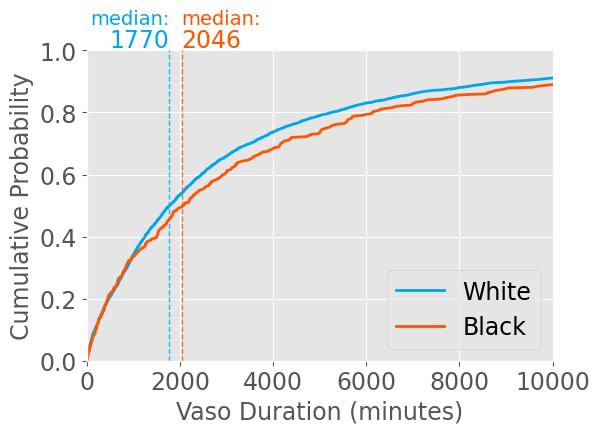

vent
	white: 4536 2520.0
	black: 484 3180.0
	p-value: 0.01584768996821058


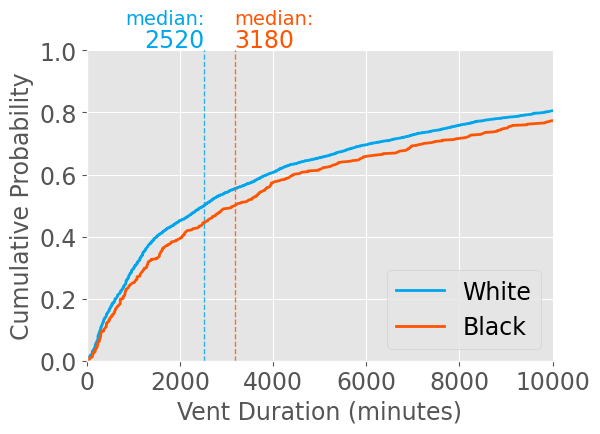

In [27]:
def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)//2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#00A6ED', '#FF5400']
for treatment in T.keys():
    i = 0

    fig = pl.figure(treatment)

    white_median = list_median(T[treatment]['White'].values())
    black_median = list_median(T[treatment]['Black'].values())
    larger_median = min(white_median, black_median)

    for demographic in ['White', 'Black']:
        vals = list(T[treatment][demographic].values())
        pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        pl.xlim((0,10000))
        pl.ylim((0,1.0))

        median = np.sort(vals)[int(len(vals)/2)]
        pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8)
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
        pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = pl.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    pl.yticks(fontsize=17)
    pl.xticks(fontsize=17)

    pl.legend(loc=4, fontsize=17)
    pl.ylabel("Cumulative Probability", fontsize=17)
    pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

    pl.tight_layout()
    #pl.savefig('../images/chapter3/race_mimic_%s.png' % treatment)

    p1 = list(T[treatment]['White'].values())
    p2 = list(T[treatment]['Black'].values())
    w = mannwhitneyu(p1, p2)
    print(treatment)
    print('\twhite:', len(p1), white_median)
    print('\tblack:', len(p2), black_median)
    print('\tp-value:', w.pvalue)

    pl.show()

Race-based Treatment Disparities, Stratified by Severity

In [28]:
# load oasis severity scores
oasis_query = 'select hadm_id, max(o.oasis) as oasis from {source}.oasis as o group by hadm_id'.format(source = derived_dataset_3)
if limited_sample:
  oasis_query += ' LIMIT 1000'
oasis_df = run_query(oasis_query)
#print(oasis_df.head())
severities = dict(oasis_df[['hadm_id','oasis']].values)
print(len(severities))

Downloading: 100%|██████████|
57786


In [29]:
treatment_severity_populations = {treatment:[] for treatment in T.keys()}
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)

treatment_severity_thresholds = {}
for treatment,scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print(treatment, vals[n//3], vals[2*n//3], '||', len(vals[:n//3]), len(vals[n//3:2*n//3]), len(vals[2*n//3:]))
    treatment_severity_thresholds[treatment] = vals[n//3], vals[2*n//3]

100%|██████████| 2/2 [00:00<00:00, 187.69it/s]

vaso 34 42 || 1537 1537 1537
vent 35 43 || 1673 1673 1674


In [30]:
# partition by treatment
T_risk = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            # acuity bin
            severity = severities[hadm_id]
            if severities[hadm_id] <= treatment_severity_thresholds[treatment][0]:
                acuity = 'low'
            elif severities[hadm_id] <= treatment_severity_thresholds[treatment][1]:
                acuity = 'medium'
            else:
                acuity = 'high'

            T_risk[treatment][acuity][race].append(amount)

for treatment,cohorts in T_risk.items():
    print(treatment)
    for severity in ['low', 'medium', 'high']:
        print('\t', severity)
        cohort = cohorts[severity]
        for race,ids in cohort.items():
            print('\t\t', race, len(ids))

100%|██████████| 2/2 [00:00<00:00, 137.32it/s]

vaso
	 low
		 Black 144
		 White 1419
	 medium
		 Black 136
		 White 1460
	 high
		 Black 141
		 White 1311
vent
	 low
		 Black 154
		 White 1549
	 medium
		 Black 165
		 White 1646
	 high
		 Black 165
		 White 1341


vaso
	 vaso low
		white: 1419 1345.0
		black: 144 1505.0
		p-value: 0.3051437968191735


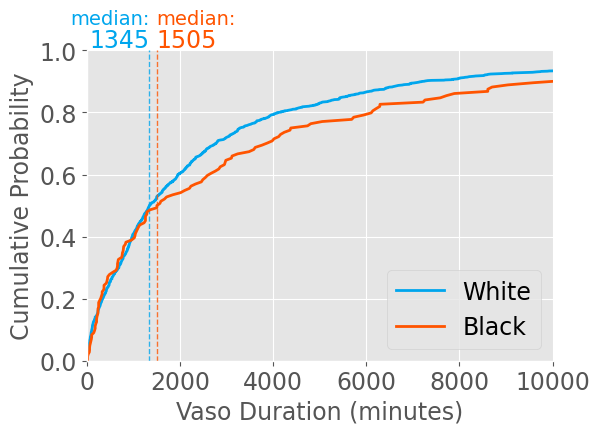

	 vaso medium
		white: 1460 1740.0
		black: 136 1949.0
		p-value: 0.5686903892858842


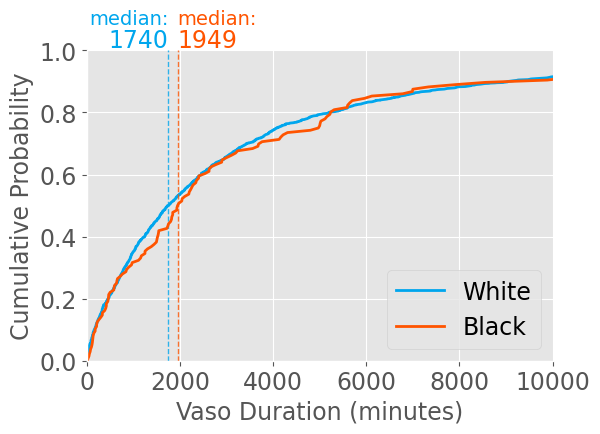

	 vaso high
		white: 1311 2280.0
		black: 141 2715.0
		p-value: 0.3562506823420486


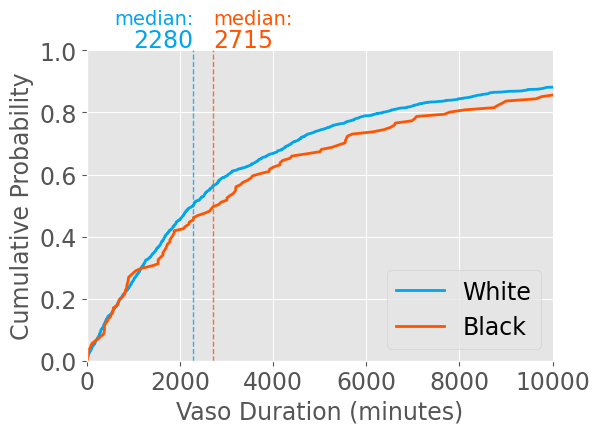

vent
	 vent low
		white: 1549 1500.0
		black: 154 3220.0
		p-value: 0.0006682578396586828


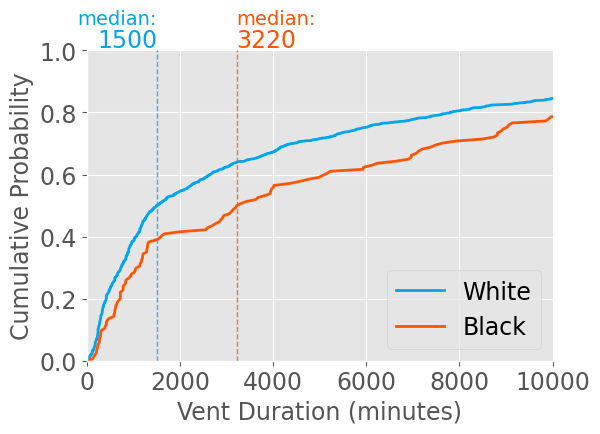

	 vent medium
		white: 1646 2710.0
		black: 165 2775.0
		p-value: 0.6787266758789834


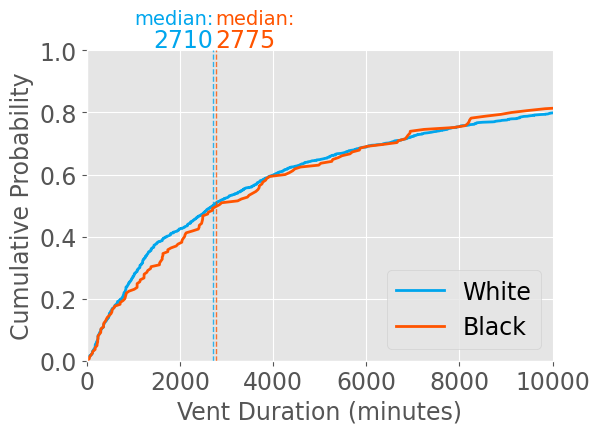

	 vent high
		white: 1341 3500.0
		black: 165 3461.0
		p-value: 0.9706422389440117


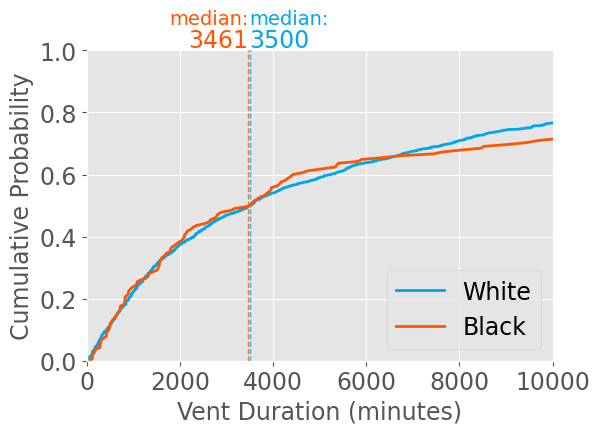

In [31]:
for treatment in T_risk.keys():
    print(treatment)

    for severity in ['low','medium','high']:
        fig = pl.figure('-'.join([treatment,severity]))
        print('\t', treatment, severity)

        white_median = list_median(T_risk[treatment][severity]['White'])
        black_median = list_median(T_risk[treatment][severity]['Black'])
        larger_median = min(white_median, black_median)

        for i,demographic in enumerate(['White', 'Black']):
            vals = list(T_risk[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
            pl.xlim((0,10000))
            pl.ylim((0,1.0))

            median = np.sort(vals)[int(len(vals)/2)]
            pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8)
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
            pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        ax = pl.subplot(111)
        ax.spines["top"].set_visible(False)
        #ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #ax.spines["left"].set_visible(False)
        pl.yticks(fontsize=17)
        pl.xticks(fontsize=17)

        pl.legend(loc=4, fontsize=17)
        pl.ylabel("Cumulative Probability", fontsize=17)
        pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

        pl.tight_layout()
        #pl.savefig('../images/chapter3/race_mimic_%s_%s.png' % (treatment,severity))

        p1 = list(T_risk[treatment][severity]['White'])
        p2 = list(T_risk[treatment][severity]['Black'])
        w = mannwhitneyu(p1, p2)
        print('\t\twhite:', len(p1), white_median)
        print('\t\tblack:', len(p2), black_median)
        print('\t\tp-value:', w.pvalue)
        pl.show()
    #exit()